In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

I downloaded the LA foreclosure datasets from 2017 to 2020.
I merged the four dataframes and extracted the longitude and latitude. Since the formats are slighly different among the four datasets, I had to swap the latitude and longitude for part of the data.
Then I grouped the data by zip code and time to generate the two plots.

In [2]:
file_name = '{}_Registered_Foreclosure_Properties.csv'
study_years = range(2017, 2021)
df = pd.concat([pd.read_csv(file_name.format(i),index_col = "APN") for i in study_years])
fc = df[['Property Zip','Registered Date','Property on Map','Property Address']]
loc = fc['Property on Map'].str.split(pat="\(|\)",expand=True)[1].str.split(pat="\,|\ ",expand=True)
fc["lon"] = pd.to_numeric(loc[0])
fc["lat"] = pd.to_numeric(loc[1])
fc.loc[fc['lon']>0,'lat'] = fc[fc['lon']>0]['lon']
fc.loc[fc['lon']>0,'lon'] = pd.to_numeric(loc[2])[fc['lon']>0]
fc = fc[np.isfinite(fc['lat'])]
fc = fc[np.isfinite(fc['Property Zip'])]
fc.loc[:,"Property Zip"] = fc['Property Zip'].apply(np.int64).astype('str')

/Users/luhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until
/Users/luhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/luhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

### Fig. 1: Total number of foreclosures across LA 2017-2020. The data here are grouped by zipcode. Multiple factors (e.g. population, average salary, unemplyment rate, crime, etc) could contribute to the regional difference of foreclosures, which provide some guidance to further pursue this project. 
The figure is an interactive map saved as "Total_Number_of_Foreclosure_map.html"

In [3]:
# load GeoJSON
with open('zip-code-tabulation-areas-2012.geojson', 'r') as jsonFile:
    data = json.load(jsonFile)
tmp = data

# remove ZIP codes not in our dataset
geozips = []
for i in range(len(tmp['features'])):
    if tmp['features'][i]['properties']['name'] in list(fc['Property Zip'].unique()):
        geozips.append(tmp['features'][i])

# creating new JSON object
new_json = dict.fromkeys(['type','features'])
new_json['type'] = 'FeatureCollection'
new_json['features'] = geozips

# save JSON object as updated-file
open("updated-file.json", "w").write(
    json.dumps(new_json, sort_keys=True, indent=4, separators=(',', ': '))
)

1925093

In [4]:
import folium
# table = main table/data frame we read from (pandas DataFrame)
# zips = column name where ZIP codes are (string)
# mapped_feature = column name for feature we want to visualize (string)
# add_text = any additional commentary to be added in the map legend (string)
def create_map(table, zips, mapped_feature, add_text = ''):
    # reading of the updated GeoJSON file
    la_geo = r'updated-file.json'
    # initiating a Folium map with LA's longitude and latitude
    m = folium.Map(location = [34.0522, -118.2437], zoom_start = 11)
    # creating a choropleth map
    m.choropleth(
        geo_data = la_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        # refers to which key within the GeoJSON to map the ZIP code to
        key_on = 'feature.properties.name',
        # first element contains location information, second element contains feature of interest
        columns = [zips, mapped_feature],
        fill_color = 'RdYlGn',
        legend_name = (' ').join(mapped_feature.split('_')).title() + ' ' + add_text + ' Across LA'
    )
    folium.LayerControl().add_to(m)
    # save map with filename based on the feature of interest
    m.save(outfile = mapped_feature + '_map.html')

In [5]:
tol_fc = fc.groupby('Property Zip').size().rename('Total_Number_of_Foreclosure')
create_map(tol_fc, 'Property Zip', 'Totoal_Number_of_Foreclosure', '2017~2020')


/Users/luhan/anaconda3/lib/python3.7/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### Fig 2: Number of foreclosures in LA in different months from 2017 to 2020. In Jan ~ April, the number of foreclosures are much higher in 2020 compared to the other three years, suggesting Covid-19 could be another important factor. However, in May ~ September, the number of foreclosures are slightly lower in 2020 compared to the earlier years, possibly due to the CARES Act Mortgage Forbearance. This suggests that policy impact on housing market should also be considered.

In [6]:
fc['month'] = fc["Registered Date"].apply(pd.to_datetime, errors='coerce').dt.to_period('M')

In [7]:
ts = fc.groupby("month").size().reset_index()
ts.columns = ['m', 'Number of Foreclosures']

In [8]:
ts['Month'] = ts['m'].dt.month
ts['Year'] = ts['m'].dt.year

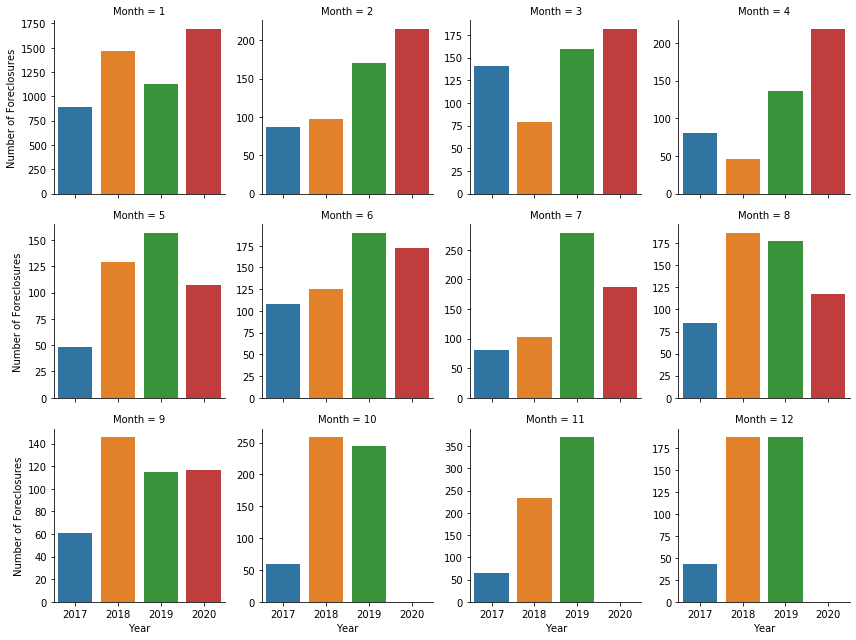

In [9]:
g = sns.FacetGrid(ts, col="Month", hue="Year", col_wrap=4, height=3,sharey=False)
g.map(sns.barplot, "Year", "Number of Foreclosures", order=[2017,2018,2019,2020])
g.savefig("foreclosures_each_year.png")